In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt

In [ ]:
# 读取数据
df = pd.read_csv('data/atmospheric_radiation_dataset.csv')

# 分离输入和输出
X = df[['p', 'T','density']].values
Y = df[['up_flux', 'down_flux']].values
print(X.shape,Y.shape)

(5000, 3) (5000, 2)


In [3]:
# 输入归一化
scaler_X = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)
print(X_scaled.shape)
# 输出归一化
scaler_Y = MinMaxScaler()
Y_scaled = scaler_Y.fit_transform(Y)
print(Y_scaled.shape)

(5000, 3)
(5000, 2)


In [4]:
X = X_scaled.reshape(100, 50, 3)  # 100个case，每个case有50层，每层3个特征
Y = Y_scaled.reshape(100, 50, 2)  # 100个case，每个case有50层，每层2个输出（up_flux, down_flux）

In [11]:
# 划分训练集和测试集
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
print(X_train.shape)

# 转换为 PyTorch 张量
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
Y_train_tensor = torch.tensor(Y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
Y_test_tensor = torch.tensor(Y_test, dtype=torch.float32)

# 输出形状确认
print(f"训练集 X 形状: {X_train_tensor.shape}, Y 形状: {Y_train_tensor.shape}")
print(f"测试集 X 形状: {X_test_tensor.shape}, Y 形状: {Y_test_tensor.shape}")

(80, 50, 3)
训练集 X 形状: torch.Size([80, 50, 3]), Y 形状: torch.Size([80, 50, 2])
测试集 X 形状: torch.Size([20, 50, 3]), Y 形状: torch.Size([20, 50, 2])


In [12]:
# 创建 DataLoader
train_loader = DataLoader(TensorDataset(X_train_tensor, Y_train_tensor), batch_size=32, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test_tensor, Y_test_tensor), batch_size=32, shuffle=False)

In [28]:
class RadiationCNN(nn.Module):
    def __init__(self):
        super(RadiationCNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=3, out_channels=64, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv1d(64, 64, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.fc = nn.Linear(64, 2)  # 每层预测两个通量: 向上和向下

    def forward(self, x):
        x = x.permute(0, 2, 1)  # (batch, 3, 50)
        x = self.relu1(self.conv1(x))
        x = self.relu2(self.conv2(x))
        x = x.permute(0, 2, 1)  # (batch, 50, 64)
        x = self.fc(x)           # (batch, 50, 2)
        return x


In [29]:
# Initialize model
model = RadiationCNN()  # 3 features per layer
print(model)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

RadiationCNN(
  (conv1): Conv1d(3, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (relu1): ReLU()
  (conv2): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (relu2): ReLU()
  (fc): Linear(in_features=64, out_features=2, bias=True)
)


In [30]:
# 训练模型
num_epochs = 50
# Training loop
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    optimizer.zero_grad()  # Clear previous gradients
    output = model(X_train_tensor)  # Forward pass

    # Flatten the model's output to (batch_size * 50, 2)
    output_flat = output.reshape(-1, 2)  # Reshaping to (batch_size * 50, 2)
    
    # Flatten Y_train_tensor to (batch_size * 50, 2)
    Y_train_flat = Y_train_tensor.reshape(-1, 2)  # Reshaping to (batch_size * 50, 2)

    # Compute the loss
    loss = criterion(output_flat, Y_train_flat)
    
    loss.backward()  # Backpropagate the loss
    optimizer.step()  # Update the model parameters

    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")



Epoch [10/50], Loss: 0.0540
Epoch [20/50], Loss: 0.0544
Epoch [30/50], Loss: 0.0473
Epoch [40/50], Loss: 0.0441
Epoch [50/50], Loss: 0.0436


In [32]:
# 验证
model.eval()
with torch.no_grad():
    Y_pred = model(X_test_tensor)  # 测试集的预测结果
    test_loss = criterion(Y_pred, Y_test_tensor)  # 计算测试集损失
    print(f"Test Loss: {test_loss.item():.4f}")

Test Loss: 0.0553


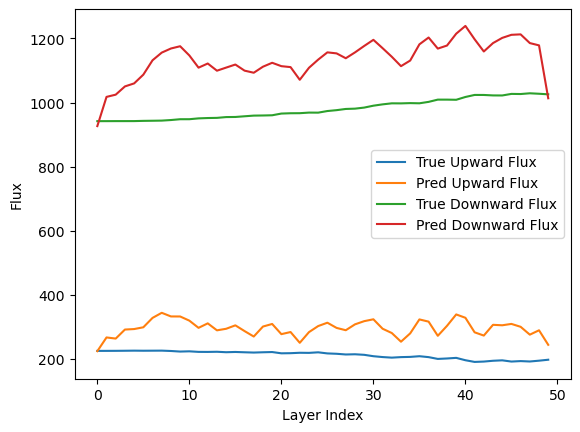

In [34]:
# 反归一化输出
Y_pred = scaler_Y.inverse_transform(Y_pred.reshape(-1, 2)).reshape(-1, Y_test.shape[1], 2)
Y_true = scaler_Y.inverse_transform(Y_test.reshape(-1, 2)).reshape(-1, Y_test.shape[1], 2)

# 可视化结果
sample_idx = 0  # 可视化第一个样本
plt.plot(Y_true[sample_idx, :, 0], label="True Upward Flux")
plt.plot(Y_pred[sample_idx, :, 0], label="Pred Upward Flux")
plt.plot(Y_true[sample_idx, :, 1], label="True Downward Flux")
plt.plot(Y_pred[sample_idx, :, 1], label="Pred Downward Flux")
plt.xlabel("Layer Index")
plt.ylabel("Flux")
plt.legend()
plt.show()
